# Suppmentary Analysis

The following code is a supplementary analysis done on cell specific DHS data (K562 as cancerous and as GM12878 healthy cell types). The aim was to use only non-sequence data on DHS peaks, e.g. relative position, width, mean signal, and derived features.

Training an XGBboost classifier on the following dataset suggests that non-sequence DHS data could also be the carrier of some relevant information that could, albeit weakly, separate healthy and cancerous cells. The feature importance analysis seems to show that signal strength is an important feature in separating the two categories of cells, hinting that adding signal strength and other positional variables to a sequence model could enhance model accuracy and provide novel insight.

Please note that this analsysis is by no means complete and conclusive work, and a significant amount of follow-up work needs to be done to validate the results here.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_feather('data.ftr')


# Feature engineering
df['DHS_width'] = df['end'] - df['start']
df['peak_sharpness'] = df['mean_signal'] / df['DHS_width']
df['relative_summit_position'] = (df['summit'] - df['start']) / df['DHS_width']
df['signal_variability'] = df['mean_signal'] / df['numsamples']
df['total_accessibility'] = df['mean_signal'] * df['DHS_width']
df['per_sample_signal_strength'] = df['mean_signal'] / df['numsamples']

# Define features and target (excluding 'component')
features = ['DHS_width', 'summit', 'mean_signal',
            'peak_sharpness', 'relative_summit_position', 'signal_variability',
            'total_accessibility', 'per_sample_signal_strength',
]
target = 'is_cancer'  # Replace with your actual target column name

# Data preprocessing and encoding
numeric_features = features

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Bundle preprocessing for numeric data only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Define the model
xgb = XGBClassifier(random_state=42)

# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', xgb)])

# Split data into train and test sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from tqdm import tqdm
import numpy as np

param_dist = {
    'classifier__n_estimators': randint(100, 300),
    'classifier__learning_rate': uniform(0.01, 0.19),  # 0.01 to 0.2
    'classifier__max_depth': randint(3, 8),  # 3 to 7
    'classifier__colsample_bytree': uniform(0.6, 0.3),  # 0.6 to 0.9
    'classifier__subsample': uniform(0.6, 0.3),  # 0.6 to 0.9
    'classifier__min_child_weight': randint(1, 6),  # 1 to 5
    'classifier__gamma': uniform(0, 0.3)  # 0 to 0.3
}

# Number of iterations to sample
n_iter_search = 30

# Initialize progress bar
tqdm_bar = tqdm(total=n_iter_search, desc="RandomizedSearchCV Progress", position=0, leave=True)

class TQDMProgressBar:
    def __init__(self, tqdm_bar):
        self.tqdm_bar = tqdm_bar

    def __call__(self, *args, **kwargs):
        self.tqdm_bar.update(1)

# Create RandomizedSearchCV instance with a custom callback to update tqdm
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                                   n_iter=n_iter_search,  # Number of parameter settings sampled
                                   scoring='f1',  # Optimize for F1 score
                                   cv=5,  # 5-fold cross-validation
                                   verbose=0,  # Suppress verbose from RandomizedSearchCV
                                   n_jobs=-1,  # Use all available cores
                                   random_state=42,  # For reproducibility
                                   return_train_score=False)

# Define a function to fit RandomizedSearchCV with tqdm progress bar
def fit_randomized_search_with_tqdm(random_search, X_train, y_train, tqdm_bar):
    for _ in range(n_iter_search):
        random_search.fit(X_train, y_train)
        tqdm_bar.update(1)
    tqdm_bar.close()
    return random_search

# Fit RandomizedSearchCV with progress tracking
random_search = fit_randomized_search_with_tqdm(random_search, X_train, y_train, tqdm_bar)

# Best model evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Best parameters found: ", random_search.best_params_)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred_proba))

RandomizedSearchCV Progress: 100%|██████████| 30/30 [04:37<00:00,  9.27s/it]

Best parameters found:  {'classifier__colsample_bytree': 0.731800950559731, 'classifier__gamma': 0.060515760700618856, 'classifier__learning_rate': 0.1801950831779687, 'classifier__max_depth': 3, 'classifier__min_child_weight': 4, 'classifier__n_estimators': 195, 'classifier__subsample': 0.8086548259278382}
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.73      0.68      3009
           1       0.67      0.57      0.62      2921

    accuracy                           0.65      5930
   macro avg       0.65      0.65      0.65      5930
weighted avg       0.65      0.65      0.65      5930

Accuracy:  0.6510961214165262
ROC AUC:  0.7212869550654212


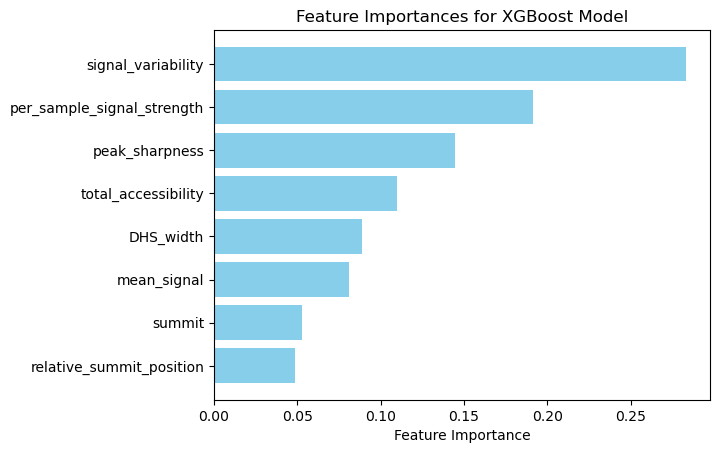

relative_summit_position: 0.04834069311618805
summit: 0.052631888538599014
mean_signal: 0.0810830295085907
DHS_width: 0.08885423094034195
total_accessibility: 0.10951288044452667
peak_sharpness: 0.14458197355270386
per_sample_signal_strength: 0.19157999753952026
signal_variability: 0.2834153473377228


In [18]:
# Feature Importance Analysis
feature_importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
all_features = numeric_features

# Sort feature importances and corresponding feature names
sorted_idx = np.argsort(feature_importances)
sorted_features = np.array(all_features)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plotting feature importances
plt.figure()
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for XGBoost Model')
plt.show()

# Print the feature importances
for feature, importance in zip(sorted_features, sorted_importances):
    print(f'{feature}: {importance}')